In [5]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import QasmSimulator
# from qiskit_ibm_provider import IBMProvider
from collections import defaultdict
import networkx as nx
from qiskit.circuit import ParameterVector, Parameter
from docplex.mp.model import Model
from itertools import combinations

service = QiskitRuntimeService()
# provider = IBMProvider()

NameError: name 'QiskitRuntimeService' is not defined

In [25]:
backends = {}
# backends["ibm_fez"] = service.backend("ibm_fez", use_fractional_gates=True)
backends["ibm_brisbane"] = service.backend("ibm_brisbane")

# qubits in line  experiment

In [ ]:
qubits_in_line = {}
# Eagle device
qubits_1D_Eagle = list(range(13,-1,-1)) + [14] + list(range(18,33)) + [36] + list(range(51,36,-1)) + [52] + list(range(56,71)) + [74] + list(range(89,74,-1)) + [90] + list(range(94,109)) + [112] + list(range(126,112,-1))
qubits_in_line["ibm_torino"] = list(range(14,-1,-1)) + [15] + list(range(19,34)) + [37] + list(range(52,37,-1)) + [53] + list(range(57,72)) + [75] + list(range(90,75,-1)) + [91] + list(range(95,110)) + [113] + list(range(128,113,-1)) + [129]
qubits_in_line["ibm_fez"] = list(range(0,16)) + [19] + list(range(35,20,-1)) + [36] + list(range(41,56)) + [59] + list(range(75,60,-1)) + [76] + list(range(81,96)) + [99] + list(range(115,100,-1)) + [116] + list(range(121,136)) + [139] + list(range(155,139,-1))



In [26]:
def cost_maxcut(bitstring, weights):
    cost = 0
    for i, j in weights.keys():
        if bitstring[i] + bitstring[j] in ["10","01"]:
            cost += weights[i,j]
    return cost

def objective_MaxCut(samples_dict, G, optimal):
    weights = {(i,j):(G[i][j]["weight"] if len(G[i][j]) != 0 else 1) for i, j in G.edges}
    max_cost = cost_maxcut(optimal, weights)
    results = []
    probability = 0
    for bitstring, counts in samples_dict.items():
        cost = cost_maxcut(bitstring, weights)
        r  = cost/max_cost
        results.append([cost, r, counts])
        if abs(cost - max_cost) < 1e-4:
            probability += counts
        if cost > max_cost:
            print(f"There is a better cost than that of CPLEX: {cost - max_cost}")
            print(f" optimal: {optimal}")
            print(f" current: {bitstring}")
    results = np.array(results)
    shots = np.sum(results[:,2])
    rT = np.sum(results[:,0] * results[:,2])/(shots*max_cost)
    probability /= shots
    return {"results":np.array(results), "G":G, "weights":weights, "max_cut":max_cost, "r":rT, "probability":probability}

def mitigate(samples_dict, G, random=False):
    change = {"0":"1", "1":"0"}
    nq = G.number_of_nodes()
    weights = {(i,j):(G[i][j]["weight"] if len(G[i][j]) != 0 else 1) for i, j in G.edges}
    new_samples = defaultdict(int)
    for bitstring, counts in samples_dict.items():
            for _ in range(counts):
                best_string = bitstring
                best_cost = cost_maxcut(bitstring, weights)
                list_qubits = np.arange(nq)
                if random:
                    np.random.shuffle(list_qubits)
                for qi in list_qubits:
                    new_string = "".join((change[i] if n == qi else i) for n, i in enumerate(best_string))
                    new_cost = cost_maxcut(new_string, weights)
                    if new_cost > best_cost:
                        best_string = new_string
                        best_cost = new_cost
                new_samples[best_string] += 1
    return new_samples

def random_samples(num_samples, n_qubits):
    random_samples = defaultdict(int)
    for i in range(num_samples):
        random_samples["".join(str(i) for i in np.random.choice([0,1], n_qubits))] += 1
    return random_samples

def repeat_subgraph(G, qubits_line):
    n_qubits = G.number_of_nodes()
    n_reps = len(qubits_line)//n_qubits
    GT = nx.Graph()
    GT.add_nodes_from(qubits_line[:n_reps * n_qubits])
    for rep in range(n_reps):
        for i, j in G.edges:
            w = G[i][j]["weight"]
            GT.add_weighted_edges_from([[qubits_line[i+rep*n_qubits], qubits_line[j+rep*n_qubits], w]])
    return GT

def WMaxCut(G):
    # MIS model as a QUBO problem
    mdl = Model('MaxCut')
    num_vertices = G.number_of_nodes()
    adjacency_matrix = nx.to_numpy_matrix(G)
    x = {i: mdl.binary_var(name=f"x_{i}") for i in range(num_vertices)}
    mdl.minimize(-mdl.sum(adjacency_matrix[i,j]*(x[i] * (1 - x[j]) + x[j] * (1 - x[i]))  for (i, j) in G.edges))
    return mdl

def shortest_path(nq_chain, G_entropy):
    num_qubits = G_entropy.number_of_nodes()
    paths = []
    S_total = []
    for i in range(num_qubits):
        for j in range(i+1, num_qubits):
            sp = nx.shortest_path(G_entropy, source=i, target=j, weight="weight")
            # list_paths = nx.all_simple_paths(G_entropy, source=i, target=j, cutoff=nq_chain)
            # for sp in list_paths:
            if len(sp) == nq_chain:
                Sab = 0
                for k in range(nq_chain-1):
                    # if [sp[k],sp[k+1]] != [99,115]:
                    Sab += G_entropy[sp[k]][sp[k+1]]["weight"]
                paths.append(sp)
                S_total.append(Sab)
    return np.array(S_total), paths

# Prepare problems

In [6]:
problems = np.load("./Data/WMC_FC.npy", allow_pickle=True).item()


# QAOA without assumptions

In [103]:
def qaoa(gammas, betas,  G):
    p = len(gammas) 
    num_qubits = G.number_of_nodes()
    nodes = range(num_qubits)
    qc = QuantumCircuit(num_qubits, len(nodes))
    qc.h(nodes)
    for pi in range(p):
        for i, j in G.edges:
            if abs(G[i][j]["weight"]) > 1e-6:
                qc.rzz(2 * gammas[pi] * G[i][j]["weight"], i, j)
        qc.rx(-2 * betas[pi], nodes)
    qc.measure(nodes, reversed(range(len(nodes))))
    return qc

def qaoa_depth(gammas, betas,  G):
    nodes = len(G.nodes())
    edges = [(i,j) for i, j in G.edges()]
    max_w = np.max(np.abs([G[i][j]["weight"] for i, j in G.edges()]))
    layers = len(gammas)
    qc = QuantumCircuit(nodes)
    qc.h(range(nodes))
    for p in range(layers):
        permutations = np.arange(nodes) # To decrease the depth of the circuit
        for jj in range(nodes):
            for k in range(jj % 2, nodes - 1, 2):
                qubit_pair = (permutations[k], permutations[k+1])
                if qubit_pair in edges or reversed(qubit_pair) in edges:
                    # qc.rzz(2 * gammas[p] * G[qubit_pair[0]][qubit_pair[1]]["weight"]/max_w, *qubit_pair)
                    qc.rzz(gammas[p], *qubit_pair)
                permutations[[k, k+1]] = permutations[[k+1, k]]
        # qc.rx(-2*betas[p], range(nodes))
        qc.rx(betas[p], range(nodes))
    # qc.measure(range(nodes), reversed(range(nodes)))
    return qc

# Naive 1D-Chain SWAP

In [28]:
def layer_1D_full_Graph(G, gamma):
    num_qubits = G.number_of_nodes()
    permutation = np.arange(num_qubits)
    max_weight = np.max(np.abs([G[i][j]["weight"] for i, j in G.edges()]))
    layer = QuantumCircuit(num_qubits) # Add a layer to the swap network
    for i in range(num_qubits):
        for j in range(i % 2, num_qubits-1, 2):
            # Determine which matrix element is required from the current permutation
            # Add the ZZ evolution gate with this matrix element
            layer.cx(j, j+1)
            layer.rz(2 * G[permutation[j]][permutation[j+1]]["weight"] * gamma / max_weight, j+1)
            layer.cx(j+1, j)
            layer.cx(j, j+1)
            permutation[[j, j+1]] = permutation[[j+1, j]]
    return layer

def qaoa_swap_network(G, gammas, betas):
    """
    Function that creates a QAOA algorithm with a full swap network for a 1D architecture.
    This is useful if the QUBO problem contains combinations between all variables,
    i.e., all possible qubit pairs need to be connected.
    """
    #Method to design the quantum circuit 

    #obtain the values for our qubo input
    #there are the quadratic and linear coeffs.

    num_qubits = G.number_of_nodes()
    p = len(gammas)

    circ = QuantumCircuit(num_qubits)
    #Apply the initial layer of Hadamard gates to all qubits
    for i in range(num_qubits):
        circ.h(i)
    circ.barrier()
    #Outer loop to create each layer
    layer = lambda gamma: layer_1D_full_Graph(G, gamma)
    for pi in range(p):
        circ = circ.compose(layer(gammas[pi]), range(num_qubits) if not pi % 2 else reversed(range(num_qubits)))
        circ.rx(-2 * betas[pi], range(num_qubits))
        circ.barrier()
    if p % 2 == 0:
        circ = circ.reverse_bits()        
    return circ 

# TKet mapping

In [3]:
from pytket.architecture import Architecture
from pytket.placement import GraphPlacement
from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit
from pytket.passes import RoutingPass
from pytket.transform import Transform
from pytket.extensions.qiskit.qiskit_convert import get_avg_characterisation, process_characterisation

def tket_mapping(qc, coupling_map):
    arc = Architecture(coupling_map)
    tkqc = qiskit_to_tk(qc)
    
    timeout = 30000  # Initial timeout in milliseconds (30 seconds)
    max_timeout = 3600000  # Maximum timeout set to 1 hour (3,600,000 milliseconds)

    while True:
        try:
            placer = GraphPlacement(arc, timeout=timeout)
            placer.place(tkqc)
            break  # If successful, exit the loop
        except RuntimeError as e:
            if "execution time has exceeded allowed limits" in str(e):
                if timeout >= max_timeout:
                    raise RuntimeError("GraphPlacement failed with maximum timeout")
                timeout = min(timeout * 2, max_timeout)  # Double the timeout, but cap at max_timeout
            else:
                raise  # Re-raise any other RuntimeError that isn’t timeout-related
                
    
    RoutingPass(arc).apply(tkqc)
    # Transform
    Transform.DecomposeBRIDGE().apply(tkqc)
    Transform.DecomposeSWAPtoCX(arc).apply(tkqc)
    Transform.RemoveRedundancies().apply(tkqc)
    tqc_tket_qiskit = tk_to_qiskit(tkqc)
    tqc_tket = transpile(tqc_tket_qiskit, basis_gates=["h", "rz","rx","rzz", "cx", "cz"], coupling_map=coupling_map, optimization_level=3)
    print('tket_to_qiskit_qc', tqc_tket.count_ops())
    return tqc_tket


In [15]:
from qiskit_ibm_transpiler.transpiler_service import TranspilerService
cloud_transpiler_service = TranspilerService(
    backend_name="ibm_fez",
    ai="True",
    optimization_level=3,
    use_fractional_gates=True
)

# Generate random problems with a minimum connectivity

In [18]:
seed = 3
np.random.seed(seed)
nqs = range(20, 121, 10)
problems = {"G":{}, "nqs":nqs, "probs":{}}
for nq in nqs:
    print(f"------- {nq} --------")
    min_edges = 2 * nq
    max_edges = nq * (nq - 1) / 2
    probs = np.round(np.linspace(min_edges/max_edges, 1, 10),3)
    problems["probs"][nq] = probs
    problems["G"][nq] = {}
    for prob in probs:
        num_edges = np.ceil(prob * max_edges)
        G = nx.Graph()
        G.add_nodes_from(range(nq))
        qubits = np.arange(nq)
        np.random.shuffle(qubits) # Adding a tree to ensure connectivity 
        G.add_weighted_edges_from([[qubits[i],qubits[i+1], round(np.random.rand(), 2)] for i in range(nq-1)])
        possible_edges = list(combinations(range(nq), 2))
        np.random.shuffle(possible_edges)
        for i, j in possible_edges:
            if (i,j) not in G.edges():
                G.add_weighted_edges_from([[i, j, round(np.random.rand(), 2)]])
            if G.number_of_edges() == num_edges:
                break
        problems["G"][nq][prob] = G
# np.save(f"./Data/problems_transpilers_{seed}.npy", problems)

------- 20 --------
------- 30 --------
------- 40 --------
------- 50 --------
------- 60 --------
------- 70 --------
------- 80 --------
------- 90 --------
------- 100 --------
------- 110 --------
------- 120 --------


In [ ]:
from qiskit.circuit import Parameter, ParameterVector
import time
methods = {"qaoa":qaoa_depth}
# methods["swap_permutations"] = aoqmap_circ_noncomplete
nq = 40
nqs = [20,30,40,50,60,70,80]
nqs = [60]
seeds = [1]
methods_used = ["qaoa"]
for nq in nqs:
    print(f"/n ----- nq: {nq} -------/n")
    map_1D = [[i,i+1] for i in range(nq-1)] + [[i+1,i] for i in range(nq-1)]
    map_HE = backends["ibm_brisbane"].configuration().coupling_map
    map_HE += [[j,i] for [i,j] in map_HE]
    # map_HE = np.load("./Data/coupling_map_HE.npy", allow_pickle=True)
    gammas = ParameterVector(length=1, name=r"$\gamma$")
    betas = ParameterVector(length=1, name=r"$\beta$")

    for seed in seeds:
        print(f" ----- seed: {seed} -------")
        operations = defaultdict(dict)
        operations = np.load(f"./Data/{nq}_transpiler_{seed}.npy", allow_pickle=True).item()
        problems = np.load(f"./Data/problems_transpilers_{seed}.npy", allow_pickle=True).item()
        probs = problems["probs"][nq]
        for method_name in methods_used:
            func = methods[method_name]
            # print(f"Method: {method_name}")
            # operations["swap"] = {}
            for prob in probs[:1]:
                print(f"probs: {prob}")
                G = problems["G"][nq][prob]
                qc = func(gammas, betas, G)
                if method_name == "qaoa":
                    operations["FC"][prob] = qc.count_ops()
                    operations["FC"][prob]["depth"] = qc.depth()
                    ti = time.time()
                    qc_he = transpile(qc, coupling_map=map_HE, basis_gates=["h", "rz","rx","rzz", "cx", "cz"],optimization_level=3)
                    tf = time.time()
                    operations["HE"][prob] = qc_he.count_ops()
                    operations["HE"][prob]["time"] = tf - ti
                    operations["HE"][prob]["depth"] = qc_he.depth()

                    # ti = time.time()
                    # qc_1d = transpile(qc, basis_gates=["h", "rz","rx","rzz", "cx", "cz"], coupling_map=map_1D)
                    # tf = time.time()
                    # operations["1D"][prob] = qc_1d.count_ops()
                    # operations["1D"][prob]["time"] = tf - ti
                    # operations["1D"][prob]["depth"] = qc_1d.depth()
                    # ti = time.time()
                    # try:
                    #     qc_ai = cloud_transpiler_service.run(qc)
                    #     operations["ai"][prob] = qc_ai.count_ops()
                    #     operations["ai"][prob]["depth"] = qc_ai.depth()
                    # except:
                    #     operations["ai"][prob] = {}
                    #     print("Couldn't find an ai solution!")
                    # tf = time.time()
                    # operations["ai"][prob]["time"] = tf - ti
                    # ti = time.time()
                    # qc_tket_he = tket_mapping(qc, coupling_map=map_HE)
                    # tf = time.time()
                    # operations["Tket-HE"][prob] = qc_tket_he.count_ops()
                    # operations["Tket-HE"][prob]["time"] = tf - ti
                    # operations["Tket-HE"][prob]["depth"] = qc_tket_he.depth()
                    
                # if method_name == "swap":
                #     ti = time.time()
                #     qc = transpile(qc[0], basis_gates=["h", "rz","rx","rzz", "cx", "cz"], coupling_map=map_1D, optimization_level=0)
                #     tf = time.time()
                #     operations[method_name][prob] = qc.count_ops()
                #     operations[method_name][prob]["time"] = tf - ti
                #     operations[method_name][prob]["depth"] = qc.depth()
                # # if method_name == "swap_permutations":
                # #     ti = time.time()
                # #     qc = func(gammas, betas, G)
                # #     tf = time.time()
                # elif method_name == "parity":
                #     ti = time.time()
                #     qc = transpile(qc, basis_gates=["h", "rz","rx","rzz", "cx", "cz"], coupling_map=map_1D, optimization_level=0)
                #     tf = time.time()
                #     operations[method_name][prob] = qc.count_ops()
                #     operations[method_name][prob]["time"] = tf - ti
                #     operations[method_name][prob]["depth"] = qc.depth()

        # np.save(f"./Data/{nq}_transpiler_{seed}.npy", operations)


/n ----- nq: 60 -------/n
 ----- seed: 1 -------
probs: 0.068


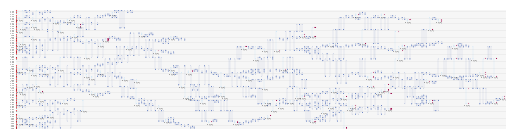

In [138]:
fig, ax = plt.subplots()
qc_he.draw("mpl", fold=-1, idle_wires=False, ax=ax)
fig.savefig("./Figures/qc_he_60.pdf", bbox_inches='tight', transparent=True)

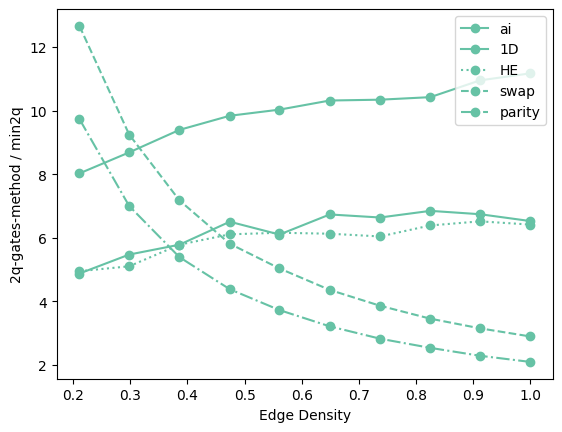

In [81]:
fig, ax = plt.subplots()
colors = plt.get_cmap("Set2")
linestyle = {"1D":"-", "HE":":", "ai":"-.", "swap":"--", "parity":"-.", "ai":"-"}
nqs = [20,30,40,50,60,70,80,90,100,110,120]
for i, nq in enumerate([20]):
    seed = 1
    operations = np.load(f"./Data/{nq}_transpiler_{seed}.npy", allow_pickle=True).item()
    probs = list(operations["FC"].keys())
    baseline = np.array([operations["FC"][prob]["rzz"] for prob in probs])
    for method in ["ai", "1D", "HE", "swap", "parity"]:
        probs = list(operations[method].keys())
        ax.plot(probs, np.array([sum([operations[method][prob][gate] for gate in ["cx", "cz", "rzz"] if gate in operations[method][prob].keys()])  for prob in probs])/baseline, color=colors(i), linestyle=linestyle[method],label=method, marker="o")
    ax.legend()
    ax.set_xlabel("Edge Density")
    ax.set_ylabel("2q-gates-method / min2q")
    # ax.set_yscale("log")
    # ax.set_yticks([1,10,100])
    # ax.set_yticklabels([1,10,100])

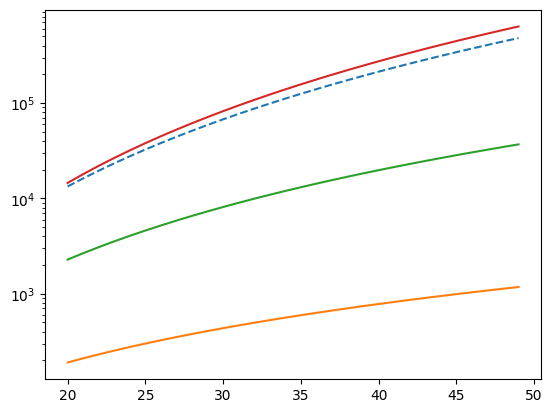

In [95]:
from itertools import combinations
nqs = range(20,50)
plt.plot(nqs, [nq**4/12 for nq in nqs], linestyle = "--")
plt.plot(nqs,[len(list(combinations(range(nq), 2))) for nq in nqs])
plt.plot(nqs,[2*len(list(combinations(range(nq), 3))) for nq in nqs])
plt.plot(nqs,[3*len(list(combinations(range(nq), 4))) for nq in nqs])
plt.yscale("log")

1D OrderedDict([('h', 742250), ('cx', 517905), ('rzz', 7140), ('rx', 120), ('time', 31.121042013168335), ('depth', 228683)])
HE OrderedDict([('cx', 131406), ('rzz', 7140), ('h', 120), ('rx', 120), ('time', 14.053345918655396), ('depth', 32336)])
swap OrderedDict([('h', 28442), ('cx', 21301), ('rz', 7140), ('rx', 120), ('time', 4.478003978729248), ('depth', 720)])
parity OrderedDict([('h', 28800), ('cx', 14399), ('rz', 7140), ('rx', 120), ('time', 3.5430452823638916), ('depth', 608)])


Text(0, 0.5, 'time [s]')

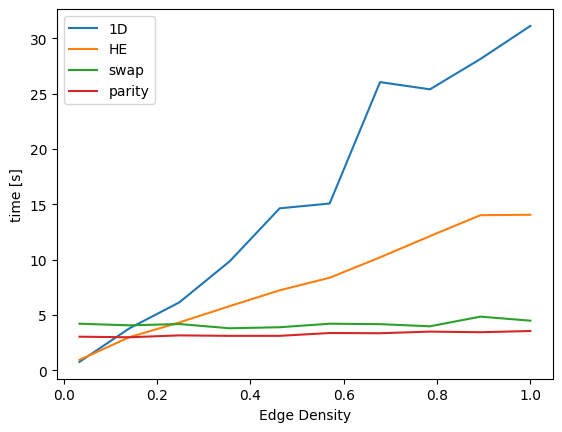

In [38]:
nq = 120
seed = 1
operations = np.load(f"./Data/{nq}_transpiler_{seed}.npy", allow_pickle=True).item()
probs = list(operations["FC"].keys())
baseline = np.array([operations["FC"][prob]["rzz"] for prob in probs])
fig, ax = plt.subplots()
for method in ["1D", "HE", "swap", "parity"]:
    nqs = operations[method].keys()
    print(method, operations[method][prob])
    gate = "cx" if method != "qaoa" else "rzz"
    ax.plot(probs, [operations[method][prob]["time"]  for prob in probs], label=method)
ax.legend()
ax.set_xlabel("Edge Density")
ax.set_ylabel("time [s]")
# ax.set_yscale("log")


1D OrderedDict([('h', 742250), ('cx', 517905), ('rzz', 7140), ('rx', 120), ('time', 31.121042013168335), ('depth', 228683)])
HE OrderedDict([('cx', 131406), ('rzz', 7140), ('h', 120), ('rx', 120), ('time', 14.053345918655396), ('depth', 32336)])
swap OrderedDict([('h', 28442), ('cx', 21301), ('rz', 7140), ('rx', 120), ('time', 4.478003978729248), ('depth', 720)])
parity OrderedDict([('h', 28800), ('cx', 14399), ('rz', 7140), ('rx', 120), ('time', 3.5430452823638916), ('depth', 608)])


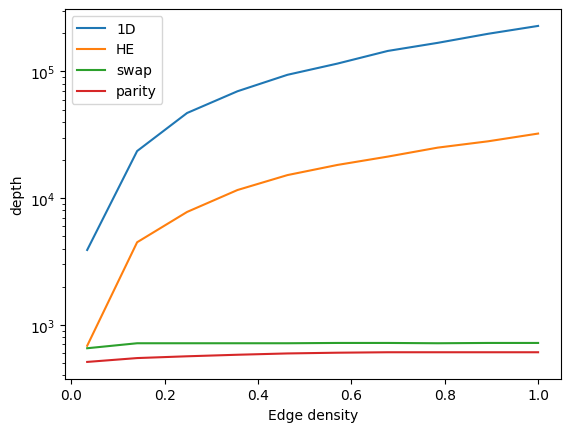

In [39]:
nq = 120
seed = 1
operations = np.load(f"./Data/{nq}_transpiler_{seed}.npy", allow_pickle=True).item()
probs = list(operations["FC"].keys())
baseline = np.array([operations["FC"][prob]["rzz"] for prob in probs])
fig, ax = plt.subplots()
for method in ["1D", "HE", "swap", "parity"]:
    nqs = operations[method].keys()
    print(method, operations[method][prob])
    gate = "cx" if method != "qaoa" else "rzz"
    ax.plot(probs, [operations[method][prob]["depth"]  for prob in probs], label=method)
ax.legend()
ax.set_xlabel("Edge density")
ax.set_ylabel("depth")
ax.set_yscale("log")


In [41]:
operations["Parity"].keys()

dict_keys([])

In [60]:
from scipy.optimize import fsolve

def crossing_point(x, y1, y2):
    # Fit polynomial regression (degree 2)
    degree = 2  # Adjust based on the nature of data
    coeffs1 = np.polyfit(x, y1, degree)
    coeffs2 = np.polyfit(x, y2, degree)

    # Convert to functions
    p1 = np.poly1d(coeffs1)
    p2 = np.poly1d(coeffs2)

    # Function to find x where y1 = y2
    def find_intersection(x_guess):
        return p1(x_guess) - p2(x_guess)

    # Solve for x numerically
    x_solution = fsolve(find_intersection, np.min(x))  # Use mean(x) as initial guess
    print(f"error: {x_solution}")
    x_solution = x_solution[0]  #
    
    return x_solution

In [62]:
nqs = np.arange(20,121,10)
seeds = [1,2,3]
method_1 = "HE"
method_2 = "SWAP" 
crossings = defaultdict(list)
for nq in nqs:
    for seed in seeds:
        operations = np.load(f"./Data/{nq}_transpiler_{seed}.npy", allow_pickle=True).item()
        x = list(operations[method_1].keys())
        y1 = np.array([sum([operations[method_1][prob][gate] for gate in ["cx", "cz", "rzz"] if gate in operations[method_1][prob].keys()])for prob in x])  # Example function y1 = 2x
        y2 = np.array([sum([operations[method_2][prob][gate] for gate in ["cx", "cz", "rzz"] if gate in operations[method_2][prob].keys()])for prob in x])    # Example function y2 = 11 - x
        crossings[nq].append(crossing_point(x[:4], y1[:4], y2[:4]))
np.save(f"./Data/transpilation/crossing_{method_1}_{method_2}.npy", crossings)

error: [0.48565059]
error: [0.49413105]
error: [0.46834956]
error: [0.37088671]
error: [0.39948837]
error: [0.38799455]
error: [0.35640688]
error: [0.39570136]
error: [0.36648987]
error: [0.33738126]
error: [0.32563219]
error: [0.33021063]
error: [0.31580993]
error: [0.30271654]
error: [0.31875226]
error: [0.31627385]
error: [0.31183216]
error: [0.3087049]
error: [0.30186004]
error: [0.29585009]
error: [0.29491036]
error: [0.28890595]
error: [0.28968355]
error: [0.28777593]
error: [0.29380704]
error: [0.28290301]
error: [0.28700533]
error: [0.2862681]
error: [0.28563254]
error: [0.27660867]
error: [0.28118206]
error: [0.27757299]
error: [0.28345453]


In [63]:
nqs = np.arange(20,121,10)
seeds = [1,2,3]
method_1 = "HE"
method_2 = "PTC" 
crossings = defaultdict(list)
for nq in nqs:
    for seed in seeds:
        operations = np.load(f"./Data/{nq}_transpiler_{seed}.npy", allow_pickle=True).item()
        x = list(operations[method_1].keys())
        y1 = np.array([operations[method_1][prob]["depth"] for prob in x])  # Example function y1 = 2x
        y2 = np.array([operations[method_2][prob]["depth"] for prob in x])    # Example function y2 = 11 - x
        crossings[nq].append(crossing_point(x[:4], y1[:4], y2[:4]))
np.save(f"./Data/transpilation/crossing_depth_{method_1}_{method_2}.npy", crossings)

error: [-0.02945346]
error: [0.14122151]
error: [0.0839927]
error: [0.07761667]
error: [0.09474345]
error: [0.11518409]
error: [0.06264432]
error: [0.06741586]
error: [-0.02374601]
error: [0.05726652]
error: [0.0441638]
error: [0.06135345]
error: [0.05666961]
error: [0.04255945]
error: [0.04276254]
error: [0.00463121]
error: [0.03693887]
error: [0.04667662]
error: [0.0325483]
error: [0.03435998]
error: [0.01364167]
error: [0.03347201]
error: [-0.00124784]
error: [0.01072435]
error: [0.02075062]
error: [0.01967989]
error: [0.02477478]
error: [0.02730821]
error: [0.0110849]
error: [0.01202034]
error: [0.02288683]
error: [0.0085679]
error: [0.02122626]


/var/folders/76/d4kyjysx1xgdrrs6zzs63s180000gn/T/ipykernel_8123/3965844727.py:18: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  x_solution = fsolve(find_intersection, np.min(x))  # Use mean(x) as initial guess


Text(0.5, 0, 'number of qubits')

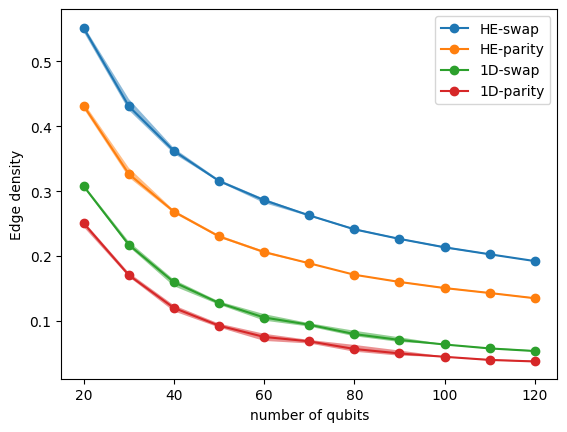

In [79]:
fig, ax = plt.subplots()
for method_1 in ["HE", "1D"]:
    for method_2 in ["swap", "parity"]:
        crossings = np.load(f"./Data/transpilation/crossing_{method_1}_{method_2}.npy", allow_pickle=True).item()

        ax.plot(nqs, [np.mean(crossings[nq]) for nq in nqs], label=f"{method_1}-{method_2}", marker="o")
        ax.fill_between(nqs, [np.min(crossings[nq]) for nq in nqs], [np.max(crossings[nq]) for nq in nqs], alpha=0.5)
ax.legend()
ax.set_ylabel("Edge density")
ax.set_xlabel("number of qubits")

# Noisy simulation

In [39]:
import qiskit_aer.noise as noise
from qiskit_aer import QasmSimulator

def create_noisy_backend(prob_1, prob_2):
    # Depolarizing quantum errors
    error_1 = noise.depolarizing_error(prob_1, 1)
    error_2 = noise.depolarizing_error(prob_2, 2)

    # Add errors to noise model
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1, ['rz', 'sx', 'x'])
    noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
    sim_noise = QasmSimulator(method="density_matrix",
                              noise_model=noise_model)
    return sim_noise

In [41]:
seed = 1
np.random.seed(seed)
nqs = [4,6,8]
problems = {"G":{}, "nqs":nqs, "probs":{}}
for nq in nqs:
    print(f"------- {nq} --------")
    min_edges = 2 * nq
    max_edges = nq * (nq - 1) / 2
    probs = np.round(np.linspace(min_edges/max_edges, 1, 3),3)
    problems["probs"][nq] = probs
    problems["G"][nq] = {}
    for prob in probs:
        num_edges = np.ceil(prob * max_edges)
        G = nx.Graph()
        G.add_nodes_from(range(nq))
        qubits = np.arange(nq)
        np.random.shuffle(qubits) # Adding a tree to ensure connectivity 
        G.add_weighted_edges_from([[qubits[i],qubits[i+1], round(np.random.rand(), 2)] for i in range(nq-1)])
        possible_edges = list(combinations(range(nq), 2))
        np.random.shuffle(possible_edges)
        for i, j in possible_edges:
            if (i,j) not in G.edges():
                G.add_weighted_edges_from([[i, j, round(np.random.rand(), 2)]])
            if G.number_of_edges() == num_edges:
                break
        problems["G"][nq][prob] = G
np.save(f"./Data/problems_noise_{seed}.npy", problems)

------- 4 --------
------- 6 --------
------- 8 --------


In [ ]:
from qiskit.circuit import Parameter, ParameterVector
import time
methods = {"qaoa":qaoa_depth, "swap":aoqmap_circ, "parity":qaoa_parity_optimal}
nqs = [4,6,8]
noise_levels = [1e-5, 1e-4, 1e-3, 1e-2]
ps = [2,4,6,9,10,15,20]
results = {}
for nq in nqs:
    results[nq] = {}
    for noise_level in noise_levels:
        results[nq][noise_level] = {}
        print(f"------- {nq} --------")
        backend = create_noisy_backend(0, noise_level)
        map_1D = [[i,i+1] for i in range(nq-1)]
        map_HE = backends["ibm_fez"].configuration().coupling_map
        for p in ps:
            gammas = ParameterVector(length=p, name="gammas")
            betas = ParameterVector(length=p, name="betas")
            for seed in [1]:
                print(f" ----- seed: {seed} -------")
                operations = defaultdict(dict)
                # operations = np.load(f"./Data/{nq}_noise_{seed}.npy", allow_pickle=True).item()
                problems = np.load(f"./Data/problems_noise_{seed}.npy", allow_pickle=True).item()
                probs = problems["probs"][nq]
                for method, func in methods.items():
                    print(f"Method: {method}")
                    operations[method] = {}
                    for prob in probs:
                        G = problems["G"][nq][prob]
                        qc = func(gammas, betas, G)

                        if method == "qaoa":
                            operations["FC"][prob] = qc.count_ops()
                            operations["FC"][prob]["depth"] = qc.depth()
                            ti = time.time()
                            qc_he = transpile(qc, coupling_map=map_HE, basis_gates=["h", "rz","rx","rzz", "cx", "cz"], optimization_level=3)
                            tf = time.time()
                            # operations["HE"][prob] = qc_he.count_ops()
                            # operations["HE"][prob]["time"] = tf - ti
                            # operations["HE"][prob]["depth"] = qc_he.depth()
                            # ti = time.time()
                            # qc_1d = transpile(qc, basis_gates=["h", "rz","rx","rzz", "cx", "cz"], coupling_map=map_1D)
                            # tf = time.time()
                            # operations["1D"][prob] = qc_1d.count_ops()
                            # operations["1D"][prob]["time"] = tf - ti
                            # operations["1D"][prob]["depth"] = qc_1d.depth()
                            # ti = time.time()
                            # try:
                            #     qc_ai = cloud_transpiler_service.run(qc)
                            #     operations["ai"][prob] = qc_ai.count_ops()
                            #     operations["ai"][prob]["depth"] = qc_ai.depth()
                            # except:
                            #     operations["ai"][prob] = {}
                            #     print("Couldn't find an ai solution!")
                            # tf = time.time()
                            # operations["ai"][prob]["time"] = tf - ti
                            # ti = time.time()
                            # qc_tket_he = tket_mapping(qc, coupling_map=map_HE)
                            # tf = time.time()
                            # operations["Tket-HE"][prob] = qc_tket_he.count_ops()
                            # operations["Tket-HE"][prob]["time"] = tf - ti
                            # operations["Tket-HE"][prob]["depth"] = qc_tket_he.depth()
                            
                        if method == "swap":
                            ti = time.time()
                            qc = transpile(qc[0], basis_gates=["h", "rz","rx","rzz", "cx", "cz"], coupling_map=map_1D, optimization_level=0)
                            tf = time.time()
                        # if method == "swap_permutations":
                        #     ti = time.time()
                        #     qc = func(gammas, betas, G)
                        #     tf = time.time()
                        elif method == "parity":
                            ti = time.time()
                            qc = transpile(qc, basis_gates=["h", "rz","rx","rzz", "cx", "cz"], coupling_map=map_1D, optimization_level=0)
                            tf = time.time()
                        operations[method][prob] = qc.count_ops()
                        operations[method][prob]["time"] = tf - ti
                        operations[method][prob]["depth"] = qc.depth()

            np.save(f"./Data/{nq}_transpiler_{seed}.npy", operations)
